In [27]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datasets import Dataset, DatasetDict, load_dataset
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_context('notebook', font_scale=1.4)
plt.rcParams.update({
    'figure.figsize': (18, 8),
    'font.size': 32,
    'axes.titlesize': 28,
    'axes.labelsize': 25,
    'xtick.labelsize': 23,
    'ytick.labelsize': 23,
    'legend.fontsize': 21
})

## Load generated captions from all models for audio inference

In [28]:
base_dir = Path("../data/generated_captions")
models = ['ft', 'base', 'zero_shot']
predictions = {}

for model in models:
    predictions[model] = {}
    pred_path = base_dir / f"{model}.csv"
    if pred_path.exists():
        predictions[model] = pd.read_csv(pred_path)

print(f"\nLoaded data for {len(models)} models")


Loaded data for 3 models


### Create huggingface datasets for further analysis

In [29]:
for model in models:
    df = predictions[model]
    hf_dataset = Dataset.from_pandas(df)
    hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
    hf_dataset_dict.push_to_hub(f"bsienkiewicz/{model}-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


In [30]:
quick_test = pd.read_csv(base_dir / "quick_test.csv")
hf_dataset = Dataset.from_pandas(quick_test)
hf_dataset_dict = DatasetDict({ 'test': hf_dataset })
hf_dataset_dict.push_to_hub("bsienkiewicz/quick-test-caption-inference-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/quick-test-caption-inference-dataset/commit/cfc5ede9670d1660bd97f605626a1b475299439d', commit_message='Upload dataset', commit_description='', oid='cfc5ede9670d1660bd97f605626a1b475299439d', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/quick-test-caption-inference-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/quick-test-caption-inference-dataset'), pr_revision=None, pr_num=None)

## Analyse ConceptCaps final captions

In [31]:
final_dir = Path("../data/generated_captions/")
splits = ['train', 'validation', 'test']
captions = {}
datasets = {}

for split in splits:
    pred_path = final_dir / f"final_{split}.csv"
    df = pd.read_csv(pred_path)
    dataset = Dataset.from_pandas(df)
    captions[split] = df
    datasets[split] = dataset
    print(f"Loaded {split}: {len(df)} samples")

Loaded train: 21433 samples
Loaded validation: 1191 samples
Loaded test: 1191 samples


### Load MusicCaps for comparison

In [32]:
mc_dataset = load_dataset("google/MusicCaps", split="train")
mc_df = mc_dataset.to_pandas()
captions['mc'] = mc_df

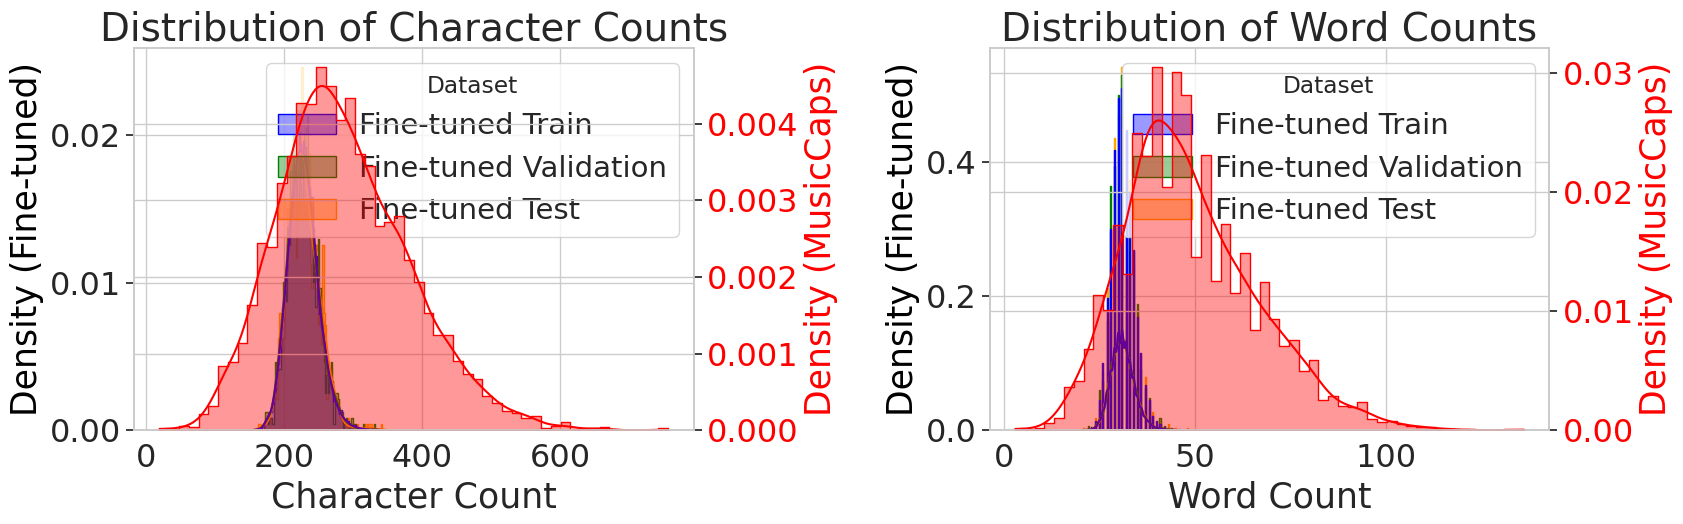

In [40]:
comparison_data = []
datasets = ['train', 'validation', 'test', 'mc']
dataset_to_name = {
    'train': 'Fine-tuned Train',
    'validation': 'Fine-tuned Validation',
    'test': 'Fine-tuned Test',
    'mc': 'MusicCaps'
}

for dataset in datasets:
    df = captions[dataset]
    col_name = 'prediction' if 'prediction' in df.columns else 'caption'
    df[col_name] = df[col_name].astype(str)
    
    word_counts = df[col_name].apply(lambda x: len(x.split()))
    char_counts = df[col_name].apply(len)
    
    # Create temporary dataframe for plotting
    temp_df = pd.DataFrame({
        'Dataset': dataset_to_name[dataset],
        'Word Count': word_counts,
        'Character Count': char_counts
    })
    comparison_data.append(temp_df)

viz_df = pd.concat(comparison_data, ignore_index=True)

# Split data
ft_df = viz_df[viz_df['Dataset'] != 'MusicCaps']
mc_df = viz_df[viz_df['Dataset'] == 'MusicCaps']

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Character counts with dual y-axis
ax0_twin = axes[0].twinx()
sns.histplot(
    data=ft_df, 
    x='Character Count', 
    hue='Dataset', 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.4, 
    ax=axes[0],
    palette={'Fine-tuned Train': 'blue', 
             'Fine-tuned Validation': 'green', 
             'Fine-tuned Test': 'orange'}
)
sns.histplot(
    data=mc_df, 
    x='Character Count', 
    kde=True, 
    element='step', 
    stat='density', 
    alpha=0.4,
    color='red',
    ax=ax0_twin,
    label='MusicCaps'
)
axes[0].set_title('Distribution of Character Counts')
axes[0].set_xlabel('Character Count')
axes[0].set_ylabel('Density (Fine-tuned)', color='black')
ax0_twin.set_ylabel('Density (MusicCaps)', color='red')
ax0_twin.tick_params(axis='y', labelcolor='red')

# Word counts with dual y-axis
ax1_twin = axes[1].twinx()
sns.histplot(
    data=ft_df, 
    x='Word Count', 
    hue='Dataset', 
    kde=True, 
    element='step', 
    stat='density', 
    common_norm=False,
    alpha=0.4,
    ax=axes[1],
    palette={'Fine-tuned Train': 'blue', 
             'Fine-tuned Validation': 'green', 
             'Fine-tuned Test': 'orange'}
)
sns.histplot(
    data=mc_df, 
    x='Word Count', 
    kde=True, 
    element='step', 
    stat='density', 
    alpha=0.4,
    color='red',
    ax=ax1_twin,
    label='MusicCaps'
)
axes[1].set_title('Distribution of Word Counts')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Density (Fine-tuned)', color='black')
ax1_twin.set_ylabel('Density (MusicCaps)', color='red')
ax1_twin.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

In [41]:
for split, df in captions.items():
    print(f"{split} - Avg Prediction Length: {df['prediction'].astype(str).apply(len).mean()}")

train - Avg Prediction Length: 228.19232025381422
validation - Avg Prediction Length: 227.88832913518053
test - Avg Prediction Length: 228.8094038623006


KeyError: 'prediction'

In [ ]:
for split, df in captions.items():
    df['word_count'] = df['prediction'].astype(str).apply(lambda x: len(x.split()))
    print(f"{split} - Avg Word Count: {df['word_count'].mean()}")

train - Avg Word Count: 69.15224187001353
validation - Avg Word Count: 69.37027707808564
test - Avg Word Count: 69.21158690176323


In [ ]:
hf_dataset_dict = DatasetDict({ split: datasets[split] for split in splits })
hf_dataset_dict.push_to_hub("bsienkiewicz/final-caption-inference-dataset")

TypeError: list indices must be integers or slices, not str